In [61]:
from transformers import AutoTokenizer, AutoModelForCausalLM

import torch
import random
import gc
import dataclasses
import tqdm
import os

import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

#from divergence_utils import visualize_states, filter_by_layer_and_position

def load_model_and_tokenizer(gpu_num, model_name="meta-llama/Llama-2-7b-chat-hf"):
    device = torch.device(f"cuda:{gpu_num}")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        #cache_dir="/data2/sjeromeh/cache/pretrained_models",
        dtype=torch.bfloat16,
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        #cache_dir="/data2/sjeromeh/cache/pretrained_models"
    )
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.eval()
    return model, tokenizer


def clear_hooks(input_hooks):
    for hook in input_hooks:
        hook.remove()
    input_hooks = []
    gc.collect()

In [62]:
try:
    from huggingface_hub import login
except:
    !pip install huggingface_hub
    from huggingface_hub import login
# either argue your huggingface token, or put it in a file
# named "your_token.txt" in the working directory
with open("your_token.txt", "r") as f:
    your_token = f.read().strip()
login(token=your_token)

# Load model and tokenizer

In [60]:
# Choose model here
# Options are keys of model_names dict below
model_alias = "llama-3-instruct"

model_names = {
    "pythia-7b": "EleutherAI/pythia-6.9b",
    "llama-3-1": "meta-llama/Llama-3.1-8B",
    "llama-3-instruct":"meta-llama/Meta-Llama-3-8B-Instruct",
    "llama-2-7b-chat": "meta-llama/Llama-2-7b-chat-hf",
}
space_token = {
    "pythia-7b": "Ġ",
    "llama-3-1": "Ġ",
    "llama-2-7b-chat": "▁",
    "llama-3-instruct":" ",
}[model_alias]
model_name = model_names[model_alias]
model, tokenizer = load_model_and_tokenizer(0, model_name=model_name)
device = model.device

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1002.00 MiB. GPU 0 has a total capacity of 44.35 GiB of which 580.12 MiB is free. Including non-PyTorch memory, this process has 18.71 GiB memory in use. Process 211849 has 25.06 GiB memory in use. Of the allocated memory 18.19 GiB is allocated by PyTorch, and 187.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Load data

In [ ]:
countries_df = pd.read_csv("data/countries.csv")
names_df = pd.read_csv("data/names.csv", index_col=0)

countries_to_capitals = countries_df.set_index("country")["capital"].to_dict()
names = names_df["name"].tolist()

# Keep only single token countries and names
countries_to_capitals = {k: v for k, v in countries_to_capitals.items() if len(tokenizer.encode(f" {k}", add_special_tokens=False)) == 1}
names = [n for n in names if len(tokenizer.encode(n, add_special_tokens=False)) == 1]

print(f"Number of countries: {len(countries_to_capitals)}, Sample: {list(countries_to_capitals.items())[:5]}")
print(f"Number of names: {len(names)}, Sample: {names[:5]}")

# Prompt generation

In [5]:
@dataclasses.dataclass(frozen=True)
class Prompt:
    context: str
    questions: list[str]
    answers: list[str]
    names: list[str]
    countries: list[str]


def generate_prompt_pair(
    num_entities,
    all_names=names,
    all_countries=list(countries_to_capitals.keys()),
    parot=False,
):
    """
    Args:
        parot: bool
            if true, will simplify the problem such that the answer
            merely requires regurgitating the already specified city.
            Otherwise, model needs to associate the countries with
            their capitals.
    """
    cs = random.sample(all_countries, num_entities*2)
    ns = random.sample(all_names, num_entities*2)

    cs_1 = cs[:num_entities]
    ns_1 = ns[:num_entities]
    cs_2 = cs[num_entities:]
    ns_2 = ns[num_entities:]

    if parot:
        target_answers = [c for c in cs_1]
        source_answers = [c for c in cs_2]
        es_1 = [f"{n} lives in {c}." for c, n in zip(target_answers, ns_1)]
        es_2 = [f"{n} lives in {c}." for c, n in zip(source_answers, ns_2)]
        target_questions = [f"Question: What country does {n} live in?" for n in ns_1]
        source_questions = [f"Question: What country does {n} live in?" for n in ns_2]
    else:
        es_1 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_1, ns_1)]
        es_2 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_2, ns_2)]
        target_answers = [countries_to_capitals[c] for c in cs_1]
        source_answers = [countries_to_capitals[c] for c in cs_2]
        target_questions = [f"Question: Which city does {n} live in?" for n in ns_1]
        source_questions = [f"Question: Which city does {n} live in?" for n in ns_2]
    target_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_1)}"
    source_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_2)}"
    return (Prompt(
        context=target_context,
        questions=target_questions,
        answers=target_answers,
        names=ns_1,
        countries=cs_1,
    ), Prompt(
        context=source_context,
        questions=source_questions,
        answers=source_answers,
        names=ns_2,
        countries=cs_2,
    ))


In [6]:
parot = False # if true, task will be to predicted the provided attributes. if false, predict cities from attributes
target_prompt, source_prompt = generate_prompt_pair(2, parot=parot)
print("Target:", target_prompt.context)
print("Questions:", target_prompt.questions)
print("Answers:", target_prompt.answers)
print()
print("Source:", source_prompt.context)
print("Questions:", source_prompt.questions)
print("Answers", source_prompt.answers)

Target: Answer the question based on the context below. Keep the answer short.

Context: Amy lives in the capital city of Ireland. Mark lives in the capital city of Mali.
Questions: ['Question: Which city does Amy live in?', 'Question: Which city does Mark live in?']
Answers: ['Dublin', 'Bamako']

Source: Answer the question based on the context below. Keep the answer short.

Context: Maria lives in the capital city of Armenia. Larry lives in the capital city of Rwanda.
Questions: ['Question: Which city does Maria live in?', 'Question: Which city does Larry live in?']
Answers ['Yerevan', 'Kigali']


# Patching experiment

In [7]:
model.model.layers[0]

LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
)

In [8]:
sublayer = "self_attn"

def save_outputs(layer: int, save_map: dict):
    """Hook function for saving the output of a model component"""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output
        save_map[layer] = proj_output.clone()
        return output
    return hook_fn


def save_hidden_states(ids, model):
    """Save the hidden states of a model. Returns model output and a (num_layers,num_tokens,hidden_size) tensor of hidden states."""
    hooks = []
    hidden_states = {}
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        if sublayer:
            model_layer = getattr(model_layer, sublayer)
        hidden_state_hook_handle = model_layer.register_forward_hook(
            save_outputs(layer, hidden_states)
        )
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
            output_hidden_states=True,
        )
    clear_hooks(hooks)
    hidden_states_tensor = torch.stack([hidden_states[i] for i in range(len(hidden_states))], dim=0).squeeze(1)
    return out, hidden_states_tensor


def replace_outputs(layer: int, target_layers: list[int], target_position: int, original_hidden_states: dict, modified_hidden_states: dict):
    """Hook function for replacing hidden states of a target layer at a target position with the hidden states from a modified prompt."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        if layer in target_layers:
            unsqueeze = len(proj_output.shape)>2
            proj_output = proj_output.squeeze()
            
            proj_output[target_position:target_position+2,:] = modified_hidden_states[layer,target_position:target_position+2,:].clone()
            
            if unsqueeze: proj_output = proj_output[None]

        if isinstance(output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def replace_hidden_states(ids, model, target_position, original_hidden_states, modified_hidden_states):
    """Replace the hidden states of a model. Returns model output."""
    hooks = []
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer,model_layer in enumerate(model_layers):
        if sublayer:
            model_layer = getattr(model_layer, sublayer)
        hidden_state_hook_handle = model_layer.register_forward_hook(
            replace_outputs(
                layer,
                list(range(len(model_layers))),
                target_position,
                original_hidden_states,
                modified_hidden_states
            )
        )
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        try:
            out = model(
                ids,
                attention_mask=torch.ones_like(ids),
                output_hidden_states=True,
            )
        except:
            clear_hooks(hooks)
            assert False
    clear_hooks(hooks)
    return out

In [9]:
def manual_decode(token_ids, tokenizer):
    decoded = []
    for tok in token_ids:
        decoded.append(tokenizer.decode(tok))
    return decoded
        
def batch_manual_decode(token_ids, tokenizer):
    all_decoded = []
    for samp in range(len(token_ids)):
        decoded = manual_decode(token_ids[samp], tokenizer)
        all_decoded.append(decoded)
    return all_decoded

In [10]:
debug = False
rows = []
nruns = 100 if not debug else 5
main_hstates = []
alt_hstates = []
mod_hstates = []
main_outputs = []
alt_outputs = []
mod_outputs = []
for run in tqdm.tqdm(range(nruns)):
    
    mp, ap = generate_prompt_pair(2)
    for query_entity_idx in range(4):
        
        query_entities = mp.names + ap.names
        questions = mp.questions + ap.questions
        if parot:
            main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in"
            alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in"
        else:
            main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"
            alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"

        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        #main_decoded_tokens = tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0])
        main_decoded_tokens = manual_decode(main_prompt_tokens["input_ids"][0], tokenizer)
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        
        #alt_decoded_tokens = tokenizer.convert_ids_to_tokens(alt_prompt_tokens["input_ids"][0])
        alt_decoded_tokens = manual_decode(alt_prompt_tokens["input_ids"][0], tokenizer)
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        main_a1_id = tokenizer(" " + mp.answers[0], add_special_tokens=False)["input_ids"][0]
        main_a2_id = tokenizer(" " + mp.answers[1], add_special_tokens=False)["input_ids"][0]
        alt_a1_id = tokenizer(" " + ap.answers[0], add_special_tokens=False)["input_ids"][0]
        alt_a2_id = tokenizer(" " + ap.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        main_list = []
        alt_list = []
        mod_list = []
        main_out_list = []
        alt_out_list = []
        mod_out_list = []
        for modify_index in [main_n1_index, main_n2_index, main_c1_index, main_c2_index]:

            # Modify hidden states by replacing with alt_hidden_states
            modified_out = replace_hidden_states(main_ids, model, modify_index, main_hidden_states, alt_hidden_states)
            main_list.append(torch.stack([
                h.squeeze()[modify_index] for h in main_out.hidden_states
            ]))
            alt_list.append(torch.stack([
                h.squeeze()[modify_index] for h in alt_out.hidden_states
            ]))
            mod_list.append(torch.stack([
                h.squeeze()[modify_index] for h in modified_out.hidden_states
            ]))
            main_out_list.append(torch.stack([
                h.squeeze()[-1] for h in main_out.hidden_states
            ]))
            alt_out_list.append(torch.stack([
                h.squeeze()[-1] for h in alt_out.hidden_states
            ]))
            mod_out_list.append(torch.stack([
                h.squeeze()[-1] for h in modified_out.hidden_states
            ]))
            modified_log_probs = F.log_softmax(modified_out.logits[0,-1,:], dim=-1)
            rows += [
                {
                    "run": run,
                    "query_name": ["e0", "e1", "e0'", "e1'"][query_entity_idx],
                    "attribute": ["a0", "a1", "a0'", "a1'"][i],
                    "swap_type": "entity" if modify_index in [main_n1_index, main_n2_index] else "attribute",
                    "swap_index": 0 if modify_index in [main_n1_index, main_c1_index] else 1,
                    "log_prob": modified_log_probs[a_id].item(),
                } for i, a_id in enumerate([main_a1_id, main_a2_id, alt_a1_id, alt_a2_id])
            ]
        main_hstates.append(torch.stack(main_list, dim=1))
        alt_hstates.append(torch.stack(alt_list, dim=1))
        mod_hstates.append(torch.stack(mod_list, dim=1))
        main_outputs.append(torch.stack(main_out_list, dim=1))
        alt_outputs.append( torch.stack(alt_out_list, dim=1))
        mod_outputs.append( torch.stack(mod_out_list, dim=1))

    df = pd.DataFrame(rows)
    if not os.path.exists(f"results/table-1/{model_alias}"):
        os.makedirs(f"results/table-1/{model_alias}")
    df.to_csv(f"results/table-1/{model_alias}/factorizability.csv", index=False)
main_hstates = torch.stack(main_hstates)
alt_hstates = torch.stack(alt_hstates)
mod_hstates = torch.stack(mod_hstates)
main_outputs = torch.stack(main_outputs)
alt_outputs = torch.stack(alt_outputs)
mod_outputs = torch.stack(mod_outputs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:02<00:00,  4.83s/it]


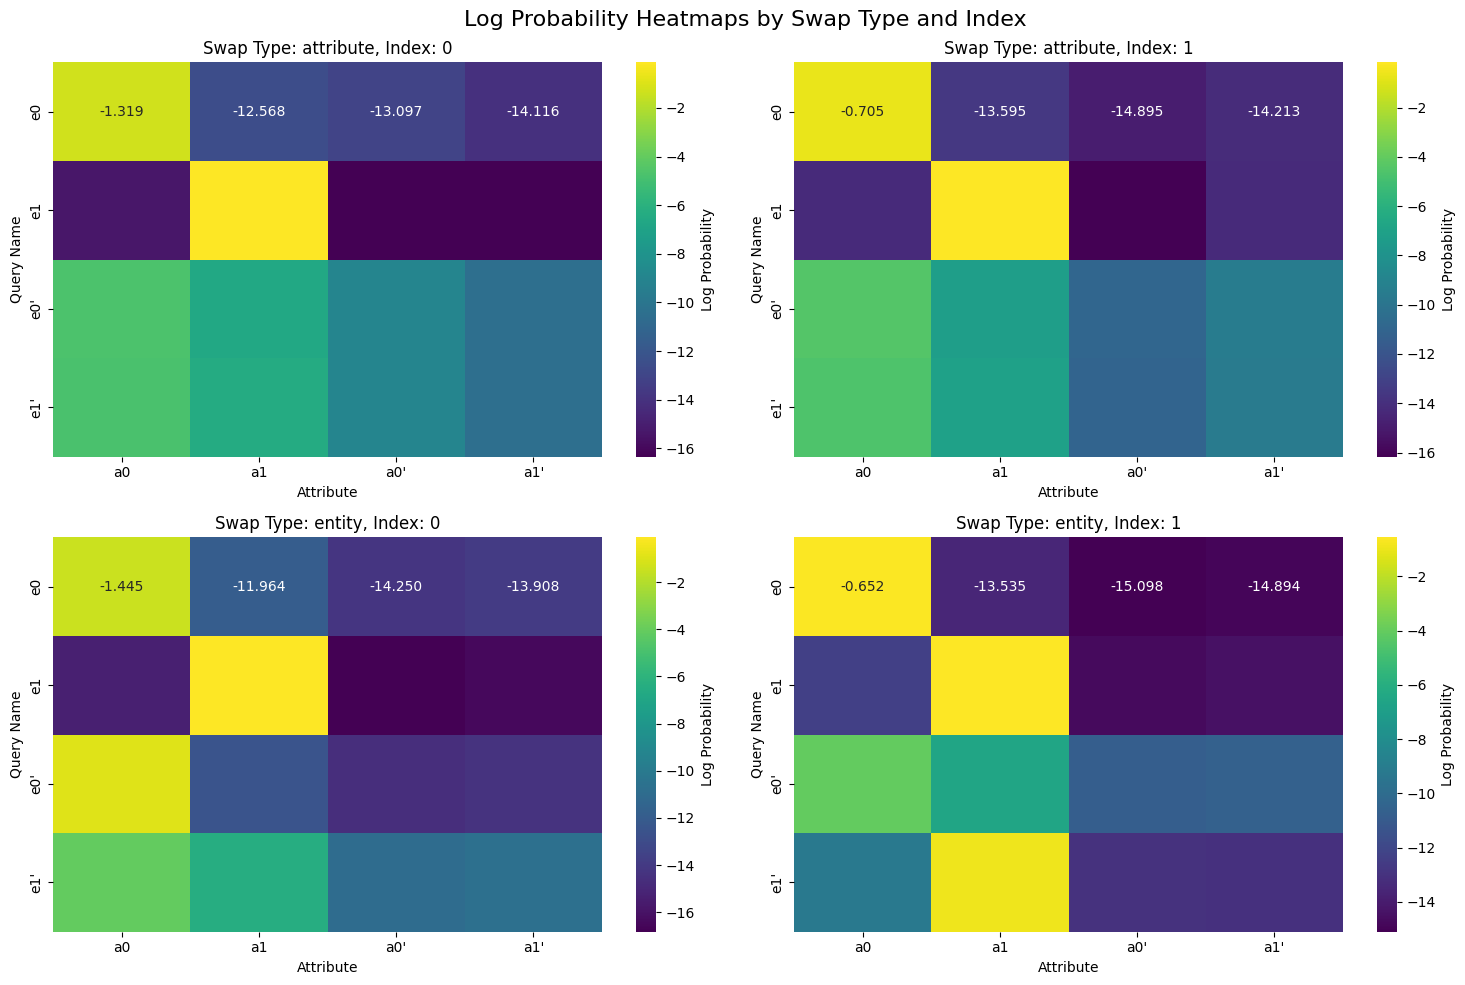

In [80]:
df = pd.read_csv(f"results/table-1/{model_alias}/factorizability.csv")
accuracy_df = df.groupby(["query_name", "attribute", "swap_type", "swap_index"]).mean().reset_index()

# Create subplots for each combination of swap_type and swap_index
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Log Probability Heatmaps by Swap Type and Index', fontsize=16)

# Define the order for consistent plotting
attribute_order = ['a0', 'a1', "a0'", "a1'"]
query_order = ['e0', 'e1', "e0'", "e1'"]

# Get unique combinations of swap_type and swap_index
swap_combinations = accuracy_df[['swap_type', 'swap_index']].drop_duplicates().sort_values(['swap_type', 'swap_index'])

for idx, (_, row) in enumerate(swap_combinations.iterrows()):
    swap_type = row['swap_type']
    swap_index = row['swap_index']
    
    # Filter data for this combination
    subset = accuracy_df[(accuracy_df['swap_type'] == swap_type) & (accuracy_df['swap_index'] == swap_index)]
    
    # Create pivot table for heatmap
    pivot_data = subset.pivot(index='query_name', columns='attribute', values='log_prob')
    
    # Reorder according to specified order
    pivot_data = pivot_data.reindex(index=query_order, columns=attribute_order)
    
    # Determine subplot position
    row_idx = idx // 2
    col_idx = idx % 2
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.3f', 
                cmap='viridis',
                ax=axes[row_idx, col_idx],
                cbar_kws={'label': 'Log Probability'})
    
    axes[row_idx, col_idx].set_title(f'Swap Type: {swap_type}, Index: {swap_index}')
    axes[row_idx, col_idx].set_xlabel('Attribute')
    axes[row_idx, col_idx].set_ylabel('Query Name')

plt.tight_layout()
plt.show()


In [16]:
main_hstates.shape

torch.Size([400, 33, 4, 4096])

In [17]:
main_outputs.shape

torch.Size([400, 33, 4, 4096])

In [76]:
def filter_by_layer_and_position(natty_hstates, intrv_hstates, layer=None, pos=None):
    """
    natty_hstates: torch tensor (B,Layer,Pos,D)
    intrv_hstates: torch tensor (B,Layer,Pos,D)
    layer: int
    pos: int
    """
    d = natty_hstates.shape[-1]
    if layer is not None:
        natty_hstates = natty_hstates[:,layer]
        intrv_hstates = intrv_hstates[:,layer]
    if pos is None:
        print(natty_hstates.shape)
        natty_states = [natty_hstates[i].reshape(-1,d) for i in range(len(natty_hstates))]
        intrv_states = [intrv_hstates[i].reshape(-1,d) for i in range(len(natty_hstates))]
    elif hasattr(pos, "__len__"):
        print(natty_hstates.shape)
        natty_states = []
        intrv_states = []
        for p in pos: 
            natty_states += [natty_hstates[i][p].reshape(-1,d) for i in range(len(natty_hstates))]
            intrv_states += [intrv_hstates[i][p].reshape(-1,d) for i in range(len(natty_hstates))]
    else:
        print(natty_hstates.shape)
        natty_states = [natty_hstates[i][pos].reshape(-1,d) for i in range(len(natty_hstates))]
        intrv_states = [intrv_hstates[i][pos].reshape(-1,d) for i in range(len(natty_hstates))]
    natty_states = torch.vstack(natty_states)
    intrv_states = torch.vstack(intrv_states)
    return natty_states, intrv_states


In [77]:
alt_hstates.shape

torch.Size([400, 33, 4, 4096])

In [78]:
natty_hstates.shape

torch.Size([400, 33, 4, 4096])

torch.Size([400, 4, 4096])

Layer: 1 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.0495, 0.0420, 0.0372, 0.0332, 0.0325])
Vis Expl Vars: tensor(0.0495) tensor(0.0420)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


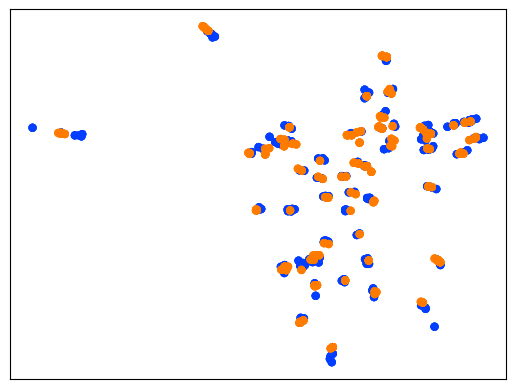

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 2 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.0488, 0.0420, 0.0359, 0.0330, 0.0307])
Vis Expl Vars: tensor(0.0488) tensor(0.0420)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


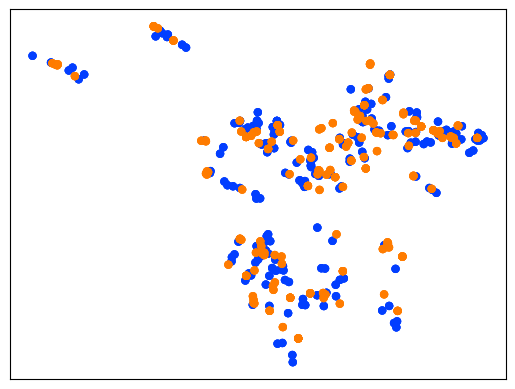

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 3 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.0561, 0.0538, 0.0451, 0.0375, 0.0340])
Vis Expl Vars: tensor(0.0561) tensor(0.0538)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


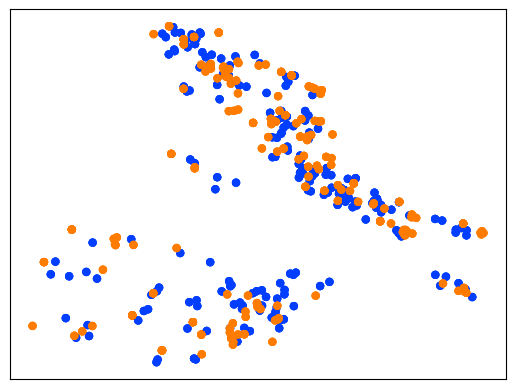

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 4 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.0603, 0.0494, 0.0474, 0.0316, 0.0296])
Vis Expl Vars: tensor(0.0603) tensor(0.0494)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


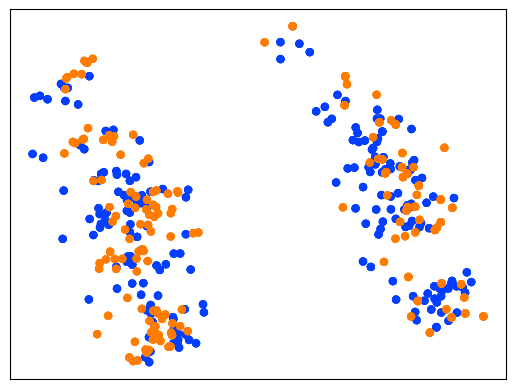

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 5 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.0789, 0.0486, 0.0441, 0.0302, 0.0286])
Vis Expl Vars: tensor(0.0789) tensor(0.0486)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


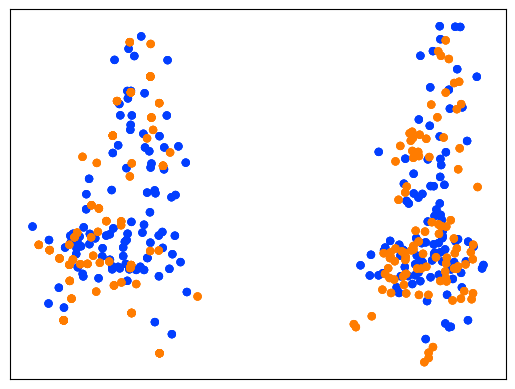

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 6 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1140, 0.0566, 0.0443, 0.0371, 0.0285])
Vis Expl Vars: tensor(0.1140) tensor(0.0566)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


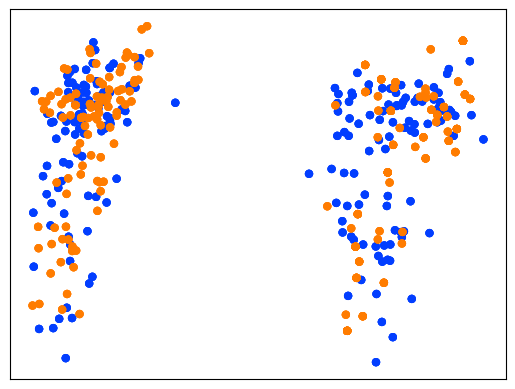

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 7 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1680, 0.0652, 0.0439, 0.0425, 0.0271])
Vis Expl Vars: tensor(0.1680) tensor(0.0652)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


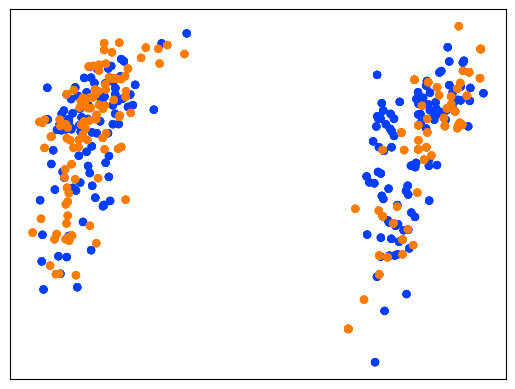

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 8 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.2103, 0.0642, 0.0449, 0.0399, 0.0280])
Vis Expl Vars: tensor(0.2103) tensor(0.0642)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


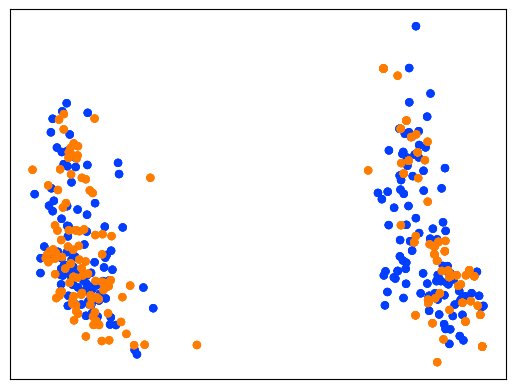

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 9 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.2445, 0.0710, 0.0440, 0.0378, 0.0334])
Vis Expl Vars: tensor(0.2445) tensor(0.0710)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


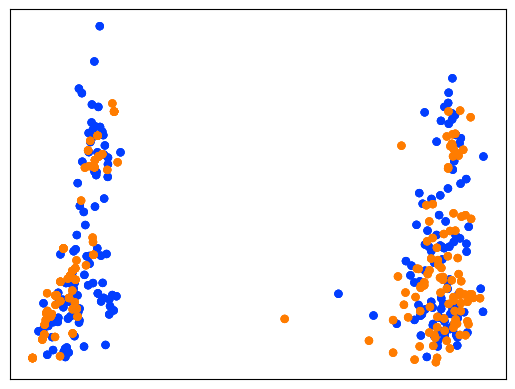

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 10 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.2802, 0.0750, 0.0438, 0.0381, 0.0299])
Vis Expl Vars: tensor(0.2802) tensor(0.0750)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


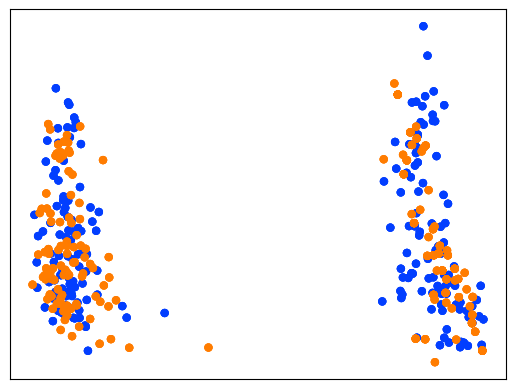

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 11 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.3034, 0.0817, 0.0431, 0.0383, 0.0299])
Vis Expl Vars: tensor(0.3034) tensor(0.0817)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


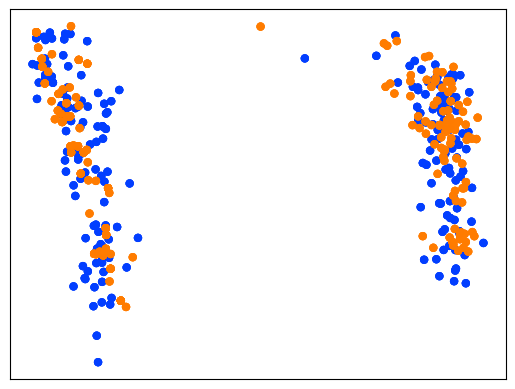

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 12 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.3413, 0.0803, 0.0407, 0.0356, 0.0279])
Vis Expl Vars: tensor(0.3413) tensor(0.0803)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


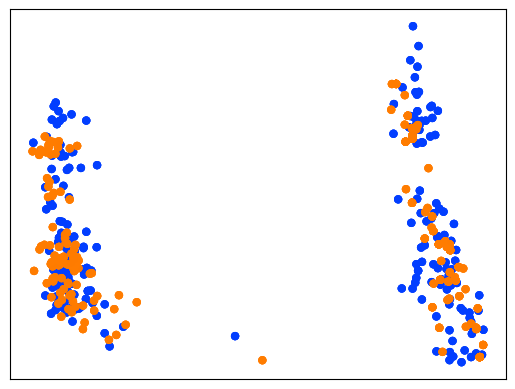

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 13 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.3306, 0.0773, 0.0410, 0.0341, 0.0253])
Vis Expl Vars: tensor(0.3306) tensor(0.0773)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


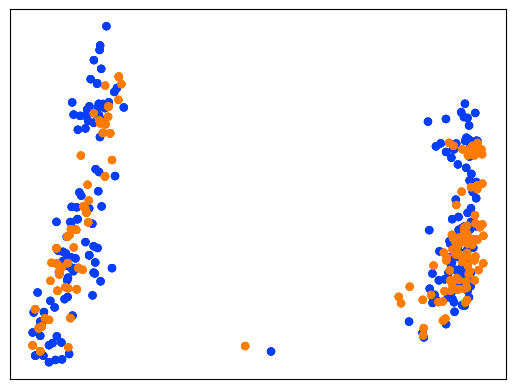

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 14 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.3229, 0.0775, 0.0414, 0.0303, 0.0263])
Vis Expl Vars: tensor(0.3229) tensor(0.0775)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


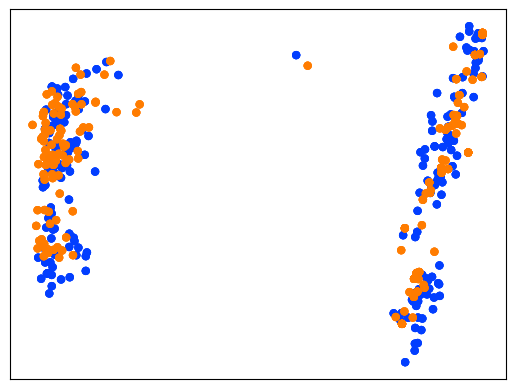

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 15 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.2894, 0.0814, 0.0427, 0.0306, 0.0268])
Vis Expl Vars: tensor(0.2894) tensor(0.0814)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


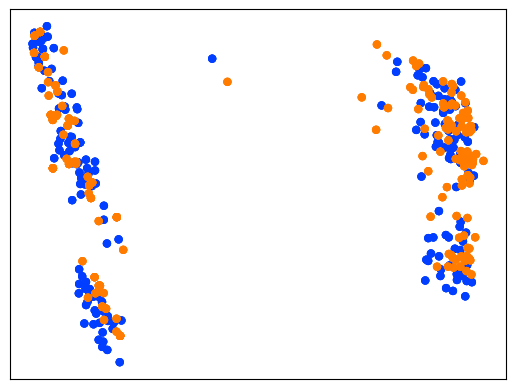

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 16 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.2502, 0.0830, 0.0474, 0.0321, 0.0315])
Vis Expl Vars: tensor(0.2502) tensor(0.0830)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


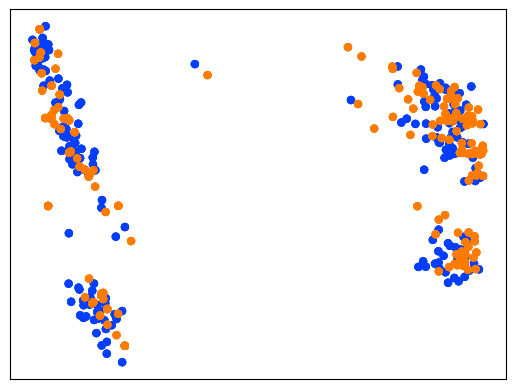

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 17 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1877, 0.0712, 0.0473, 0.0337, 0.0316])
Vis Expl Vars: tensor(0.1877) tensor(0.0712)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


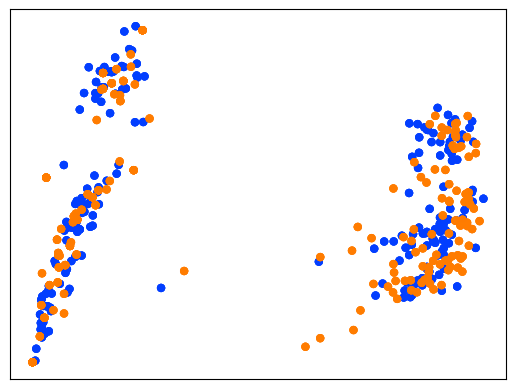

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 18 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1312, 0.0627, 0.0501, 0.0420, 0.0349])
Vis Expl Vars: tensor(0.1312) tensor(0.0627)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


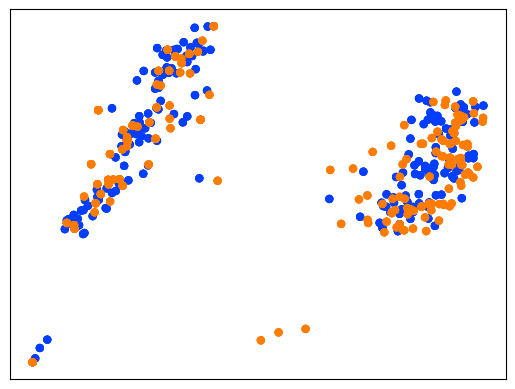

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 19 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1204, 0.0616, 0.0497, 0.0414, 0.0341])
Vis Expl Vars: tensor(0.1204) tensor(0.0616)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


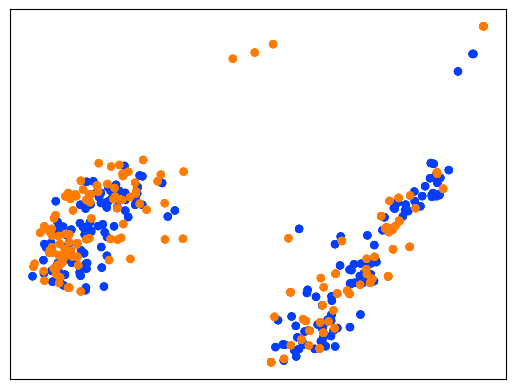

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 20 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1141, 0.0601, 0.0471, 0.0418, 0.0348])
Vis Expl Vars: tensor(0.1141) tensor(0.0601)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


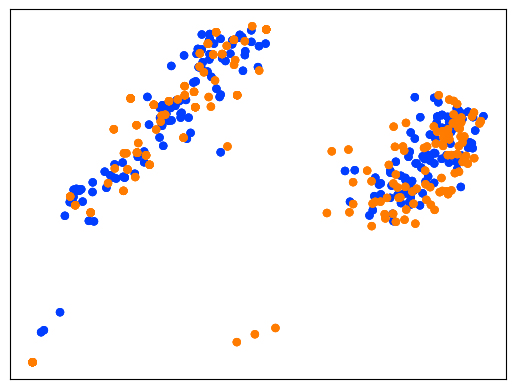

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 21 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1071, 0.0579, 0.0453, 0.0423, 0.0349])
Vis Expl Vars: tensor(0.1071) tensor(0.0579)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


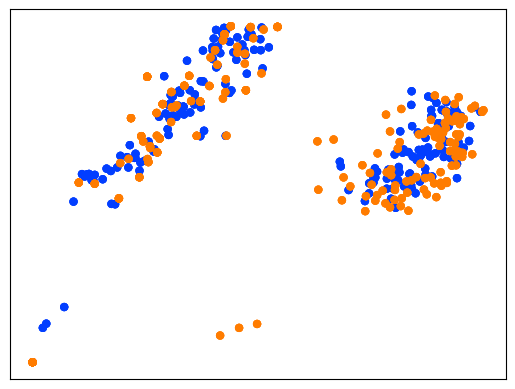

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 22 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1032, 0.0554, 0.0447, 0.0414, 0.0343])
Vis Expl Vars: tensor(0.1032) tensor(0.0554)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


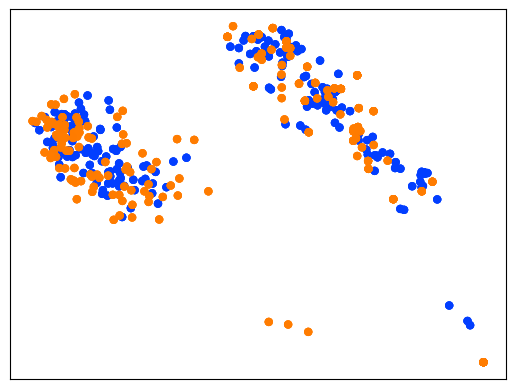

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 23 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1055, 0.0548, 0.0445, 0.0401, 0.0343])
Vis Expl Vars: tensor(0.1055) tensor(0.0548)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


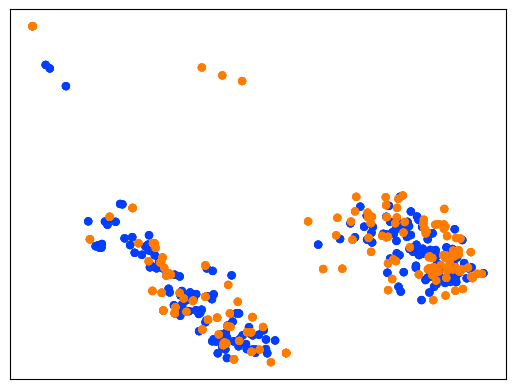

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 24 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1061, 0.0548, 0.0447, 0.0388, 0.0342])
Vis Expl Vars: tensor(0.1061) tensor(0.0548)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


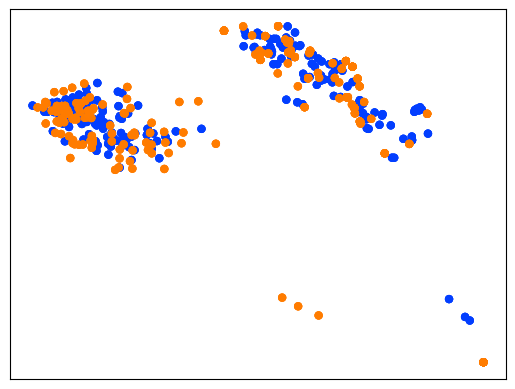

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 25 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1080, 0.0544, 0.0438, 0.0386, 0.0340])
Vis Expl Vars: tensor(0.1080) tensor(0.0544)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


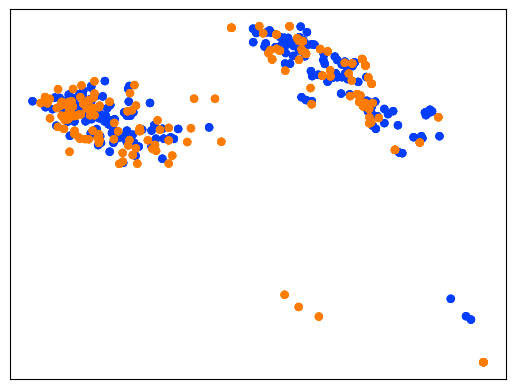

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 26 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1117, 0.0538, 0.0431, 0.0379, 0.0335])
Vis Expl Vars: tensor(0.1117) tensor(0.0538)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


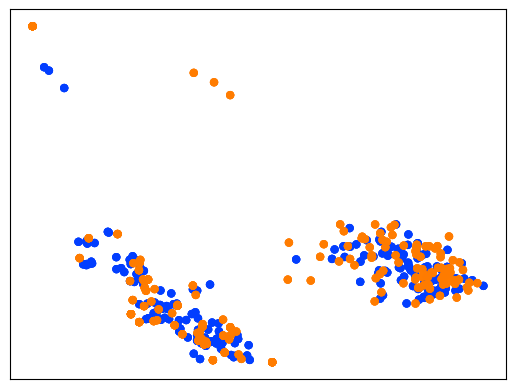

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 27 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1169, 0.0528, 0.0424, 0.0369, 0.0330])
Vis Expl Vars: tensor(0.1169) tensor(0.0528)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


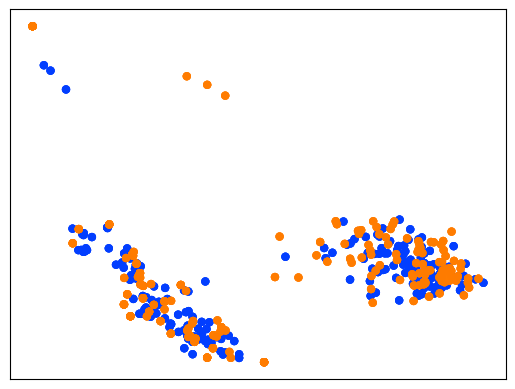

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 28 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1196, 0.0525, 0.0416, 0.0360, 0.0327])
Vis Expl Vars: tensor(0.1196) tensor(0.0525)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


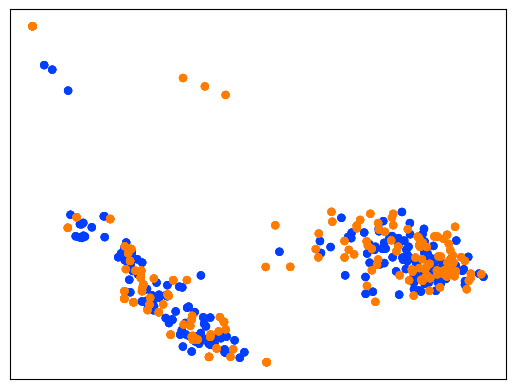

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 29 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1353, 0.0519, 0.0394, 0.0346, 0.0318])
Vis Expl Vars: tensor(0.1353) tensor(0.0519)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


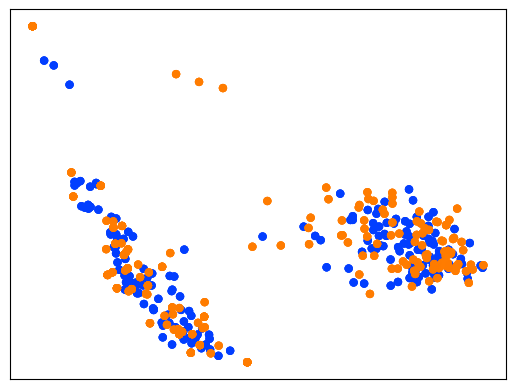

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 30 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1464, 0.0513, 0.0376, 0.0336, 0.0315])
Vis Expl Vars: tensor(0.1464) tensor(0.0513)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


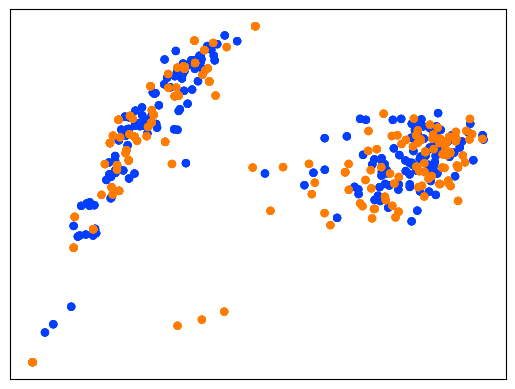

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 31 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1645, 0.0513, 0.0352, 0.0328, 0.0313])
Vis Expl Vars: tensor(0.1645) tensor(0.0513)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


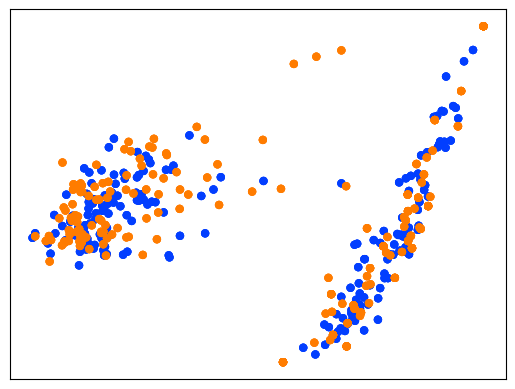

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([400, 4, 4096])

Layer: 32 Pos: [0, 1]
Natty: torch.Size([800, 4096])
Intrv: torch.Size([800, 4096])
Top Expl Vars: tensor([0.1559, 0.0554, 0.0385, 0.0346, 0.0309])
Vis Expl Vars: tensor(0.1559) tensor(0.0554)


/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:98: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:104: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


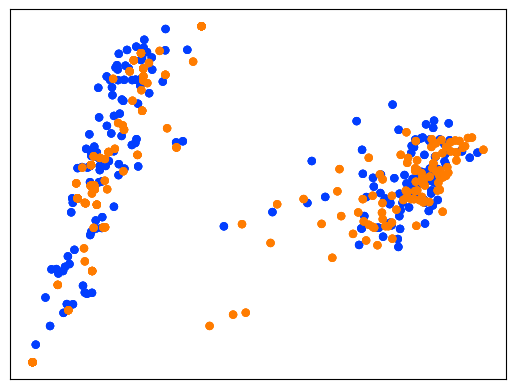

/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  )
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vecs = ret["transformed_X"]
/home/grantsrb/src/pyvene_fork/divergence/divergence_utils.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


base_emd    129.801914
emd         434.451171
dtype: float64

In [79]:
from divergence_utils import visualize_states
np.random.seed(12345)
torch.manual_seed(12345)

n_samples = 10
layers = list(range(1,natty_hstates.shape[1]))
positions = [[0,1]]

natty_hstates = alt_hstates
intrv_hstates = mod_hstates

emd_df_dict = {
    "sample_id": [],
    "pos": [],
    "layer": [],
    "mse": [],
    "emd": [],
    "base_emd": [],
}

for layer in layers:
    for pos in positions:
        natty_states, intrv_states = filter_by_layer_and_position(
            natty_hstates, intrv_hstates, layer=layer, pos=pos
        )
        
        print()
        print("Layer:", layer, "Pos:", pos)
        print("Natty:", natty_states.shape)
        print("Intrv:", intrv_states.shape)
        for samp_id in range(n_samples):
            p = str(pos)
            diffs = visualize_states(
                natty_states,
                intrv_states,
                xdim=0,
                ydim=1,
                save_name=f"figs/all_attn_heads_layer{layer}_pos{p}.png",
                expl_var_threshold=0,
                emd_sample_type="permute",
                emd_sample_size=len(natty_hstates)//2,
                normalize_emd=True,
                visualize=samp_id==0,
            )
            mse = diffs["mse"]
            emd = diffs["emd"]
            base_emd = diffs["base_emd"]
            emd_df_dict["sample_id"].append(samp_id)
            emd_df_dict["emd"].append(emd)
            emd_df_dict["base_emd"].append(base_emd)
            emd_df_dict["mse"].append(mse)
            emd_df_dict["pos"].append(pos)
            emd_df_dict["layer"].append(layer)
    
emd_df = pd.DataFrame(emd_df_dict)
emd_df[["base_emd","emd",]].mean()
    

In [71]:
d = dict(emd_df[["base_emd","emd",]].mean())
base_emd = d["base_emd"]
emd = d["emd"]
perc = (emd-base_emd)/base_emd
frac = emd/base_emd
print("EMD %:", perc)
print("EMD Frac:", frac)

EMD %: 0.6698081256869163
EMD Frac: 1.6698081256869162


In [72]:
emd_df

,sample_id,pos,layer,mse,emd,base_emd
0,0,None,1,1.83268,1261.17065,947.50049
1,1,None,1,1.83268,1308.60388,899.18201
2,2,None,1,1.83268,1255.66748,760.07086
3,3,None,1,1.83268,1245.26843,832.99115
4,4,None,1,1.83268,1271.21436,856.42993
...,...,...,...,...,...,...
315,5,None,32,0.97488,971.08020,608.65894
316,6,None,32,0.97488,949.67920,591.78638
317,7,None,32,0.97488,934.45178,652.43390
318,8,None,32,0.97488,947.96912,597.59308


In [73]:
emd_df["method"] = "attn patch"
if not os.path.exists("csvs/"):
    os.mkdir("csvs/")
emd_df.to_csv("csvs/attn_patch_emd_individuated_layer.csv", header=True, index=False)